In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [2]:
dev = qml.device('lightning.qubit', wires=4)

## Data 

In [3]:
N = 20000

In [4]:
data = np.random.normal(loc=7,scale=1.5, size=N).astype(int)

In [5]:
values, counts = np.unique(data, return_counts=True)

In [6]:
def num_bin(x):
    return np.array([1 if i == '1' else 0 for i in format(x, '#06b')[2:]])

(0.0, 16.0)

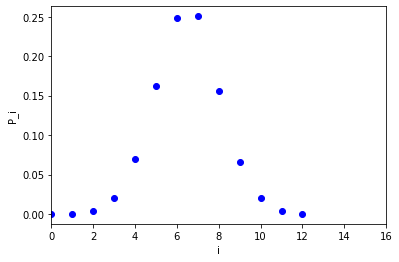

In [7]:
plt.plot(values,counts/N, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')
plt.xlim(0,16)

## Circuit ansatz

generator just a strongly entangling layer

In [8]:
def G_anastz(params, qbits):
    for i in range(4): qml.Hadamard(wires=i)
    qml.StronglyEntanglingLayers(weights=params, wires=[qbits[0],qbits[1],qbits[2],qbits[3]])

circuit for plotting

In [9]:
@qml.qnode(dev)
def circuit2(params, wires):
    G_anastz(params, wires)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_1717791/1974881317.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


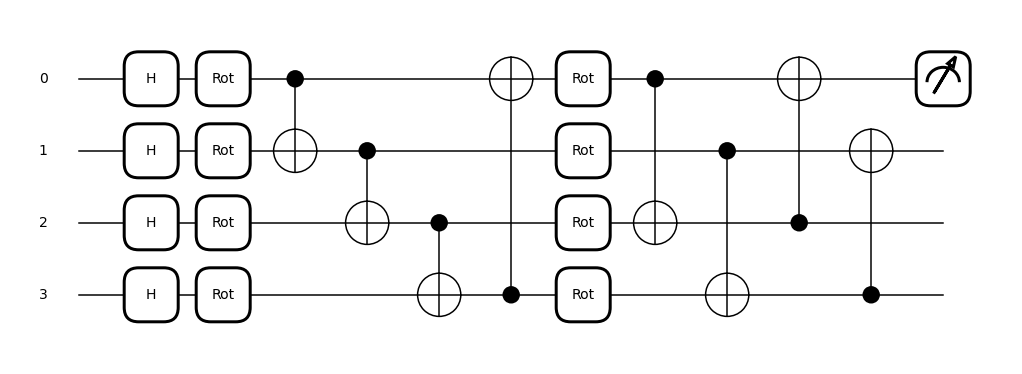

In [10]:
fig, ax = qml.draw_mpl(circuit2)(np.zeros(shape=(2,4,3)), [0,1,2,3])
fig.show()

Trianing circuit just samples form generator

In [11]:
@qml.qnode(dev, diff_method="adjoint")
def training_circ(paramsg):
    G_anastz(paramsg, [0,1,2,3])
    #return qml.sample(wires=[0,1,2,3])
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]
    #return qml.probs()

In [12]:
dev_sample = qml.device('lightning.qubit', wires=4, shots=2000)

@qml.qnode(dev_sample)
def training_circ_sample(paramsg):
    G_anastz(paramsg, [0,1,2,3])
    return qml.sample(wires=[0,1,2,3])
    #return [qml.expval(qml.PauliZ(i)) for i in range(4)]

/tmp/ipykernel_1717791/515988293.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


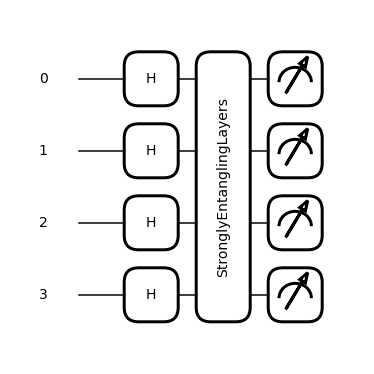

In [13]:
fig, ax = qml.draw_mpl(training_circ)(np.random.random(size=(4,4,3)))
fig.show()

sigmoid activation

In [14]:
def sig(x):
    return 1.0 / (1.0 + np.exp(-x))

Discriminator:
- Idea was to just use a two layer mlp with sigmoid activation
- for some reason if I use np.sum(in_state.astype(np.float64)) I get nonzero gradients
- cast to float is neccessary for numpy

In [67]:
def discriminator(in_state, paramsd):
    # give paramsd as (3,4,2) (which is (width neurons, input dimension, num layers)
    # I take last dim of paramsd as b
    y = sig(paramsd[:10,0,0]*in_state+paramsd[:10,0,2])
    y = np.dot(paramsd[:10,0,1].T,y)+paramsd[0,1,2]
    return sig(y)
    # return np.sum(in_state.astype(np.float64))

## Training 

In [73]:
debug_printing = 0

def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch_gen_old(paramsg, paramsd, batch, reg=0.000001):
    # I use log loss to to get proper gradients
    loss = 0.0
    for i in batch:
        f = training_circ(paramsg)
        # maybe recst measurement output to [0,1] ?
        f = (1-f)/2
        loss = loss - discriminator(f, paramsd)
        #loss = loss - discriminator(f, paramsd)
    return loss / len(batch)

def cost_batch_gen(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    samples = training_circ_sample(np.array(paramsg,requires_grad=False))
    samples = np.array(samples, requires_grad=False)
    probs = training_circ(paramsg)
    probs = (1-probs)/2
    for i in samples:
        p = 1-i.astype(np.float64) + (-1)**i.astype(np.float64)*(-probs)
        #print(probs)
        if debug_printing:
            print("probs ", p)
            print("sample: ", i)
        p = np.prod(p)
        if debug_printing: 
            print("overlap: ", p)
            print(" discriminator: ", discriminator(i, paramsd))
            print()
        #print(i)
        i = np.array(i, requires_grad=False)
        paramsd = np.array(paramsd, requires_grad=False)
        try:
            res = int("".join(str(x) for x in i._value), 2)
        except:
            res = int("".join(str(x) for x in i), 2)
        loss -= p*np.log(discriminator(res, paramsd)+reg)
    return loss / len(batch)

def cost_batch_discr_og(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(paramsg)
        # maybe recst measurement output to [0,1] ?
        f = (1-f)/2
        loss = loss + discriminator(f, paramsd)
        loss = loss - discriminator(num_bin(i), paramsd)
        #loss = loss + discriminator(f, paramsd)
        #loss = loss - discriminator(num_bin(i), paramsd)
    return loss / len(batch)

def cost_batch_discr(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    sample = np.array(training_circ_sample(np.array(paramsg,requires_grad=False)),requires_grad=False)
    for i in sample:
        res = int("".join(str(x) for x in i), 2)
        loss -= np.log(1-discriminator(res, paramsd)+reg)
        if debug_printing: print("samples: ", discriminator(res,paramsd))
    for i in batch:
        loss -= np.log(discriminator(i, paramsd)+reg)
        if debug_printing: print("data: ", discriminator(i,paramsd))
    return loss / len(batch)

In [74]:
# initialize parameters
paramsg = np.random.uniform(-0.5,0.5,size=(14,4,3), requires_grad=True)
paramsd = np.random.uniform(-0.3,0.3,size=(10,4,3), requires_grad=True)

In [75]:
epochs = 2000
batch_size=2000
learning_rate=0.001

In [76]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
optd = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

Training:
- Just loop over data
- Define lambda function for every data batch
- alter between training of generator and discriminator

In [77]:
print("initial paramsg:", paramsg)
print("initial paramsd:", paramsd)

paramsg_before = paramsg.copy()
paramsd_before = paramsd.copy()

losshistg = []
losshistd = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        if it % 2 == 0:
            cost_fn_g = lambda p: cost_batch_gen(p, paramsd, Xbatch)
            paramsg = optg.step(cost_fn_g, paramsg)
        if it % 2 == 1:
            cost_fn = lambda p: cost_batch_discr(paramsg, p, Xbatch)
            paramsd = optd.step(cost_fn, paramsd)
        print(j, end="\r")

    
    lossg = cost_batch_gen(paramsg, paramsd, data)
    lossd = cost_batch_discr(paramsg, paramsd, data)
    
    losshistg += [lossg]
    losshistd += [lossd]
    
    print("____")
    print(f"Epoch: {it} | Gen Loss: {lossg:.3} | Discr Loss: {lossd:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)
print("final paramsd:", paramsd)

initial paramsg: [[[ 0.09818345  0.03541645  0.00571976]
  [-0.0127361   0.03613851  0.07616953]
  [ 0.01779619  0.04550922  0.01767032]
  [ 0.08008447 -0.07123364 -0.00374015]]

 [[-0.00100183  0.00127995  0.02935158]
  [ 0.05908572 -0.01786254  0.04635399]
  [-0.08483117  0.08299409 -0.01508242]
  [ 0.06704531  0.02279472 -0.01689416]]

 [[ 0.06349064  0.03870614 -0.07396394]
  [-0.02293356 -0.08937257  0.08733694]
  [ 0.07144239  0.07778561  0.09166526]
  [ 0.06169823  0.05695361  0.09442304]]

 [[-0.0744419   0.02281371  0.09811765]
  [ 0.09740938  0.05911098 -0.05598749]
  [-0.04287334  0.07221367  0.00579736]
  [ 0.07122629  0.07801595  0.03596689]]

 [[-0.01002722  0.0721027  -0.09613855]
  [ 0.08412611 -0.03950072 -0.04319596]
  [ 0.08717104 -0.04390397 -0.06906143]
  [ 0.01743835  0.08326812  0.0626794 ]]

 [[ 0.07049674  0.04700519  0.03674643]
  [-0.03943395  0.08799827  0.09449836]
  [ 0.07371632  0.03347716  0.04543111]
  [-0.09112585  0.00638947 -0.00575914]]

 [[ 0.01451


KeyboardInterrupt



Check loss

Text(0, 0.5, 'loss')

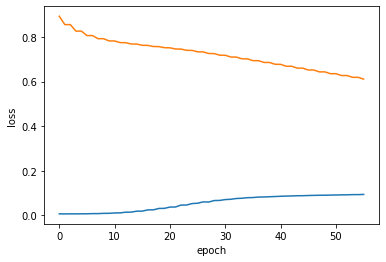

In [78]:
plt.plot(losshistg)
plt.plot(losshistd)
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale('log')

Sample from the generator as test

In [79]:
sample_dev = qml.device('lightning.qubit', wires=4, shots = N)
@qml.qnode(sample_dev)
def sample_test():
    G_anastz(paramsg, [0,1,2,3])
    return qml.sample()

In [80]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [81]:
valuestest, countstest = np.unique(testresult, return_counts=True)

In [82]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

(0.0, 16.0)

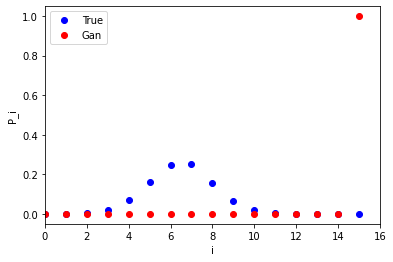

In [83]:
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="Gan")
plt.ylabel('P_i')
plt.xlabel('i')
plt.legend()
plt.xlim(0,16)